In [2]:
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future


import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score

Using TensorFlow backend.


In [3]:
import keras.backend as K

MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 5

In [4]:
print('Loading word vectors...')
word2vec = {}

with open(os.path.join('E:/Datasets/Globe6B/glove.6B.%sd.txt' % EMBEDDING_DIM) , encoding = 'utf8') as f:
    
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:] , dtype = 'float32')
        word2vec[word] = vec
    
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [5]:
print('Loading in comments...')

train = pd.read_csv("E:/Datasets/Toxic comment/train.csv" , engine = 'python')
sentences = train["comment_text"].fillna("DUMMY_VALUE").values
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[possible_labels].values

Loading in comments...


In [6]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [7]:
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))


# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Found 210496 unique tokens.
Shape of data tensor: (159571, 100)


In [8]:
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [9]:
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

In [10]:
print('Building model...')

# create an LSTM network with a single LSTM
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
# x = LSTM(15, return_sequences=True)(x)
x = Bidirectional(LSTM(15, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
output = Dense(len(possible_labels), activation="sigmoid")(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.01),
  metrics=['accuracy'],
)

Building model...


In [11]:
print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Train on 127656 samples, validate on 31915 samples
Epoch 1/5
127656/127656 [==============================] - 546s 4ms/step - loss: 0.0680 - accuracy: 0.9766 - val_loss: 0.0575 - val_accuracy: 0.9800
Epoch 2/5
127656/127656 [==============================] - 542s 4ms/step - loss: 0.0543 - accuracy: 0.9809 - val_loss: 0.0550 - val_accuracy: 0.9806
Epoch 3/5
127656/127656 [==============================] - 733s 6ms/step - loss: 0.0520 - accuracy: 0.9815 - val_loss: 0.0539 - val_accuracy: 0.9806
Epoch 4/5
127656/127656 [==============================] - 545s 4ms/step - loss: 0.0499 - accuracy: 0.9820 - val_loss: 0.0533 - val_accuracy: 0.9811
Epoch 5/5
127656/127656 [==============================] - 550s 4ms/step - loss: 0.0489 - accuracy: 0.9824 - val_loss: 0.0518 - val_accuracy: 0.9813


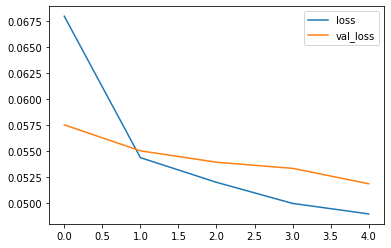

In [12]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

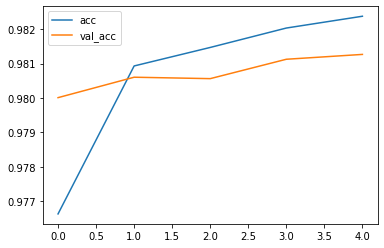

In [13]:
# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [14]:
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

0.978242295150605
